In [1]:
import sys
sys.path.append('../app/')
from psa import Strategy, Disease, Psa, Icer
from load_data import data_loader

In [2]:
import os

#file_disease = '../data/Dati Input Disease.xlsx'
#file_strategies = '../data/Dati Input Strategies.xlsx'
#file_costs = '../data/Dati Input Costs.xlsx'
#out_folder = '../output/igenomix_af'

file_disease = '../data/Dati Input Disease_Tier3.xlsx'
file_strategies = '../data/Dati Input Strategies_Tier3.xlsx'
file_costs = '../data/Dati Input Strategy Costs_Tier3.xlsx'
out_folder = '../output/ACMG_Tier3'


os.makedirs('../output',exist_ok=True)
os.makedirs(out_folder,exist_ok=True)

# Toy data

In [3]:
# Disease Definitions
d1 = Disease(name='disease1',carrier_rate=0.01,life_expectancy=80,cost=10000)
d2 = Disease(name='disease2',carrier_rate=0.02,life_expectancy=60,cost=20000)
d3 = Disease(name='disease3',carrier_rate=0.005,life_expectancy=40,cost=100000)
disease_dict_fake = {'disease1':d1,'disease2':d2,'disease3':d3}


# Strategies Definition
s0 = Strategy('No testing',disease_list=[],testing_cost=0,disease_dict=disease_dict_fake)
s1 = Strategy('Limited screening',disease_list=['disease2'],testing_cost=1000,disease_dict=disease_dict_fake)
s2 = Strategy('Full screening',disease_list=['disease1','disease2','disease3'],testing_cost=1200,disease_dict=disease_dict_fake)

strategy_dict_fake = {'s0':s0,'s1':s1,'s2':s2}




In [4]:
s0.assess_strategy(disease_space=['disease1','disease2','disease3'])

{'p_affected_total': 0.00013125,
 'life_exp': 82.99735624999998,
 'total_cost': 2.875}

In [5]:
icer1 = Icer(s2,s1)
icer1.compute_icer()
display(icer1.icer)
display(icer1.delta_years)
display(icer1.delta_costs)

785331.5958672068

0.0002542058750094611

199.6359054999998

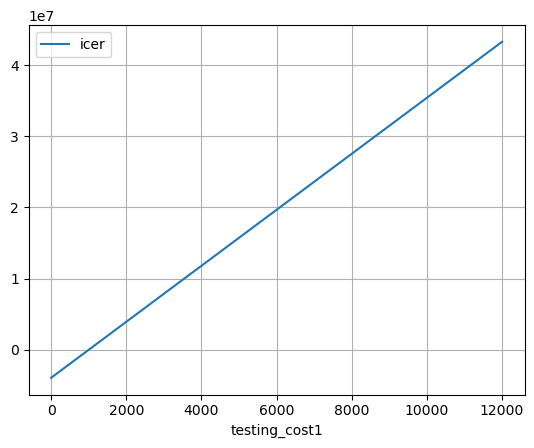

In [6]:
icer1.univariate_sensitivity('testing_cost1',0,12000,50)
icer1.plot_sensitivity()

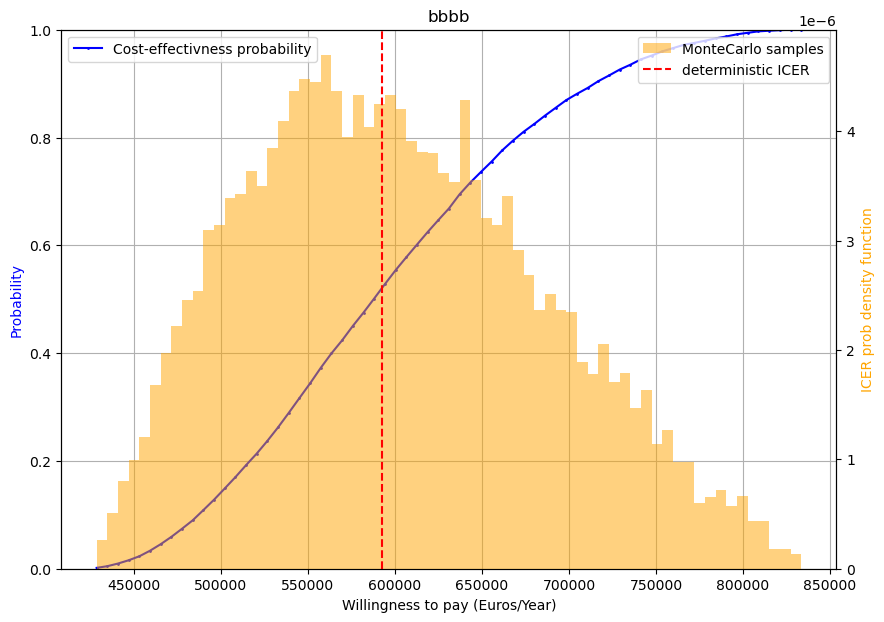

In [7]:
psa = Psa(s2,s0)
psa.run_mc(disease_space=['disease1','disease2','disease3'],
    intervention_cost_lb=2000, intervention_cost_ub=3000,
       testing_cost1_lb=1000, testing_cost1_ub=1300,
        testing_cost2_lb=0, testing_cost2_ub=0,
        eps_cs_lb=0,eps_cs_ub=0.02,
        eps_pgt_lb=0,eps_pgt_ub=0.02,
        rho_notint_lb=0.1,rho_notint_ub=0.4,nsim=10000)

psa.plot_ceac_hist(title='bbbb')

# Load real data

In [8]:


dl = data_loader(file_disease,file_strategies,file_costs=file_costs)



In [9]:
dl.disease_dict['Alpha-thalassemia (HBA1 and HBA2)'].__str__()

'Alpha-thalassemia (HBA1 and HBA2)'

In [10]:
dl.disease_dict['Alpha-thalassemia (HBA1 and HBA2)']

Disease: Alpha-thalassemia (HBA1 and HBA2)

In [11]:
for strategy in dl.strategy_dict.keys():

    display(strategy,
            dl.strategy_dict[strategy].assess_strategy(intervention_cost=19714,eps_cs=0,eps_pgt=0))

'Strategy B - Focused Screening'

{'p_affected_total': 0.0006255558380109074,
 'life_exp': 82.9926096556123,
 'total_cost': 1360.3176881379397}

'Strategy C  - ACMG tier 3'

{'p_affected_total': 0.0011447036677932798,
 'life_exp': 82.98278506221948,
 'total_cost': 1668.6452643950397}

'Strategy A - ACMG tier 1'

{'p_affected_total': 0.00022796556110962207,
 'life_exp': 82.99088727518385,
 'total_cost': 450.9942794053267}

'No testing'

{'p_affected_total': 0, 'life_exp': 83, 'total_cost': 0}

# cost effectivness plane

In [12]:
dl.strategy_dict.keys()

dict_keys(['Strategy B - Focused Screening', 'Strategy C  - ACMG tier 3', 'Strategy A - ACMG tier 1', 'No testing'])

In [13]:
import pandas as pd
df_icer = pd.DataFrame()

for comparison in [
                  #('Strategy A1 (MS)','No testing'),
    ('Strategy A - ACMG tier 1','No testing'),
    ('Strategy B - Focused Screening','No testing'),
                  ('Strategy C  - ACMG tier 3','No testing'),
                  #('Strategy A1 (MS)','Strategy C (ACOG)'),
                  #('Strategy A1 (MS)','Strategy D (ACMG)'),
                  #('Strategy A (FS)','Strategy C (ACOG)'),
                  #('Strategy A (FS)','Strategy D (ACMG)'),
                  #('Strategy A (FS)','Strategy A1 (MS)'),
                   ('Strategy C  - ACMG tier 3','Strategy A - ACMG tier 1'),
                    ('Strategy C  - ACMG tier 3','Strategy B - Focused Screening'),
                       ('Strategy B - Focused Screening','Strategy A - ACMG tier 1'),

                  ]:
    strategy1 = comparison[0]
    strategy2 = comparison[1]

    icer1 = Icer(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2],
                 eps_cs=0,eps_pgt=0,intervention_cost=19714)
    icer1.compute_icer()
    #display(icer1.disease_space)
    df_icer = df_icer.append(
        {'strategy1':strategy1,'strategy2':strategy2,
           'icer':icer1.icer,
           'total cost1':icer1.total_cost1,
           'total cost2':icer1.total_cost2,
           'life exp1':icer1.life_exp1,
           'life exp2':icer1.life_exp2,
          'benefit difference (years)':icer1.life_exp1-icer1.life_exp2,
        'cost difference (Euros)':icer1.total_cost1-icer1.total_cost2},ignore_index=True)

df_icer['cfr'] = df_icer['strategy1'].str.split('-').apply(lambda x: x[-1])+' vs '+df_icer['strategy2'].str.split('-').apply(lambda x: x[-1])

/tmp/ipykernel_419595/269318280.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer = df_icer.append(
/tmp/ipykernel_419595/269318280.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer = df_icer.append(
/tmp/ipykernel_419595/269318280.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer = df_icer.append(
/tmp/ipykernel_419595/269318280.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer = df_icer.append(
/tmp/ipykernel_419595/269318280.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer = df_icer.append(


In [14]:
df_icer.columns

Index(['strategy1', 'strategy2', 'icer', 'total cost1', 'total cost2',
       'life exp1', 'life exp2', 'benefit difference (years)',
       'cost difference (Euros)', 'cfr'],
      dtype='object')

In [15]:


df_icer

,strategy1,strategy2,icer,total cost1,total cost2,life exp1,life exp2,benefit difference (years),cost difference (Euros),cfr
0,Strategy A - ACMG tier 1,No testing,-15261.028972,450.994279,916.574972,82.990887,82.960379,0.030508,-465.580692,ACMG tier 1 vs No testing
1,Strategy B - Focused Screening,No testing,-107599.201987,1360.317688,4022.492784,82.992610,82.967868,0.024742,-2662.175096,Focused Screening vs No testing
2,Strategy C - ACMG tier 3,No testing,-47728.064971,1668.645264,4419.338591,82.982785,82.925152,0.057633,-2750.693326,ACMG tier 3 vs No testing
3,Strategy C - ACMG tier 3,Strategy A - ACMG tier 1,-84244.405131,1668.645264,3953.757898,82.982785,82.955660,0.027125,-2285.112634,ACMG tier 3 vs ACMG tier 1
4,Strategy C - ACMG tier 3,Strategy B - Focused Screening,-2691.257468,1668.645264,1757.163495,82.982785,82.949894,0.032891,-88.518230,ACMG tier 3 vs Focused Screening
5,Strategy B - Focused Screening,Strategy A - ACMG tier 1,380941.161572,1432.892479,3629.486883,82.980353,82.986119,-0.005766,-2196.594404,Focused Screening vs ACMG tier 1


In [16]:
df_icer[['strategy1','strategy2','icer','benefit difference (years)', 'cost difference (Euros)','life exp1', 'life exp2','total cost1',
       'total cost2']].to_excel(os.path.join(out_folder,'icer.xlsx'))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


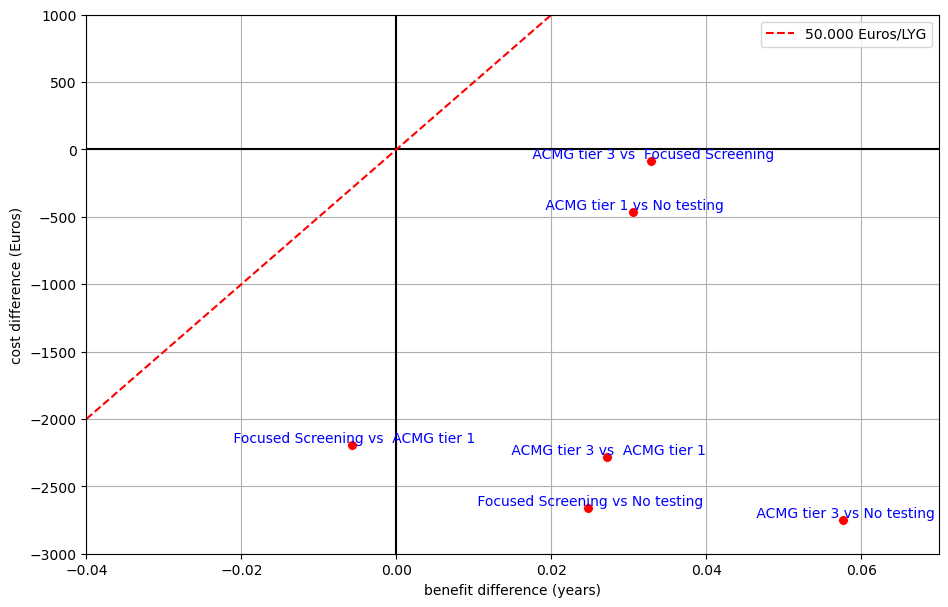

In [20]:
import seaborn as sns
from matplotlib import pyplot as plt

fig,ax = plt.subplots(figsize=(11,7))

sns.scatterplot(ax=ax,data = df_icer,x='benefit difference (years)',y='cost difference (Euros)',color='r',s=50)

plt.axhline(0,c='k')
plt.axvline(0,c='k')
plt.xlim([-0.04,0.07])
plt.ylim([-3000,1000])

icer_th = 50000
x1 = -0.04
x2 = 0.07
plt.plot([x1,x2],[x1*icer_th,x2*icer_th],ls='--',c='r',label='50.000 Euros/LYG')

for line in range(0,df_icer.shape[0]):
     plt.text(df_icer['benefit difference (years)'][line],
              df_icer['cost difference (Euros)'][line], 
              df_icer['cfr'][line], horizontalalignment='center', verticalalignment='bottom', size='medium', color='blue')#, weight='semibold')
plt.legend()
plt.grid()
plt.savefig(os.path.join(out_folder,'cost_effectivness_plane.jpeg'))
plt.savefig(os.path.join(out_folder,'cost_effectivness_plane.eps'))

# Sensitivity analysis

In [18]:
import pandas as pd

intervention_cost = 19714
rho_notint = 0.23
cost_A = dl.strategy_dict['Strategy A - ACMG tier 1'].testing_cost
cost_B = dl.strategy_dict['Strategy B - Focused Screening'].testing_cost
cost_C = dl.strategy_dict['Strategy C  - ACMG tier 3'].testing_cost

for strategy in dl.strategy_dict.keys():
    print(strategy,dl.strategy_dict[strategy].testing_cost)

Strategy B - Focused Screening 270
Strategy C  - ACMG tier 3 350
Strategy A - ACMG tier 1 180
No testing 0


/tmp/ipykernel_419595/436928842.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/436928842.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/436928842.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/436928842.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/436928842.py:43: FutureWarning: The frame.append method is deprecated and will be 

/tmp/ipykernel_419595/436928842.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/436928842.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/436928842.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/436928842.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/436928842.py:43: FutureWarning: The frame.append method is deprecated and will be 

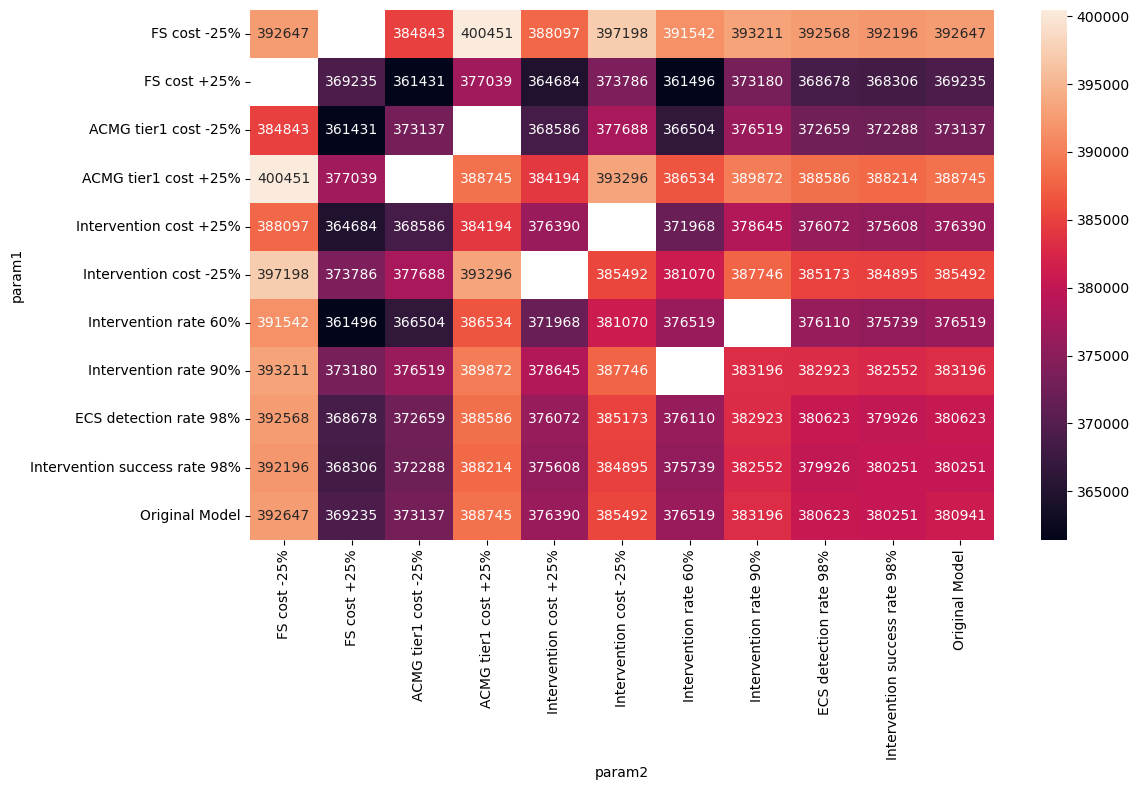

In [21]:
# A vs B


strategy1 = 'Strategy A - ACMG tier 1'
strategy2 = 'Strategy B - Focused Screening'



param_list = [
    ('testing_cost2',0.75*cost_B,'FS cost -25%'),
              ('testing_cost2',1.25*cost_B,'FS cost +25%'),
              ('testing_cost1',0.75*cost_A,'ACMG tier1 cost -25%'),
              ('testing_cost1',1.25*cost_A,'ACMG tier1 cost +25%'),
              ('intervention_cost',1.25*intervention_cost,'Intervention cost +25%'),
              ('intervention_cost',0.75*intervention_cost,'Intervention cost -25%'),
                ('rho_notint',0.4,'Intervention rate 60%'),
              ('rho_notint',0.1,'Intervention rate 90%'),
             ('eps_cs',0.02,'ECS detection rate 98%'),
             ('eps_pgt',0.02,'Intervention success rate 98%'),
    ('original_model_fake_parameter',0,'Original Model')]

df_icer_sensitivity = pd.DataFrame()

for param1 in param_list:
    for param2 in param_list:
        
        if (param1[1]!=param2[1])&(param1[0]==param2[0]):
            pass
        
        else:

            #print(param1,param2)

            icer = Icer(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2],
                     eps_cs=0,eps_pgt=0,intervention_cost=intervention_cost,rho_notint=rho_notint)
            setattr(icer,param1[0],param1[1])
            setattr(icer,param2[0],param2[1])
            
            #print(param1[2],param2[2],icer.testing_cost1,icer.testing_cost2)


            icer.compute_icer()
            df_icer_sensitivity = df_icer_sensitivity.append(
            {'param1':param1[2],'param1_value':param1[1],
             'param2':param2[2],'param2_value':param2[1],
               'icer':icer.icer,
               'total cost1':icer.total_cost1,
               'total cost2':icer.total_cost2,
               'life exp1':icer.life_exp1,
               'life exp2':icer.life_exp2,
              'benefit difference (years)':icer.life_exp1-icer.life_exp2,
            'cost difference (Euros)':icer.total_cost1-icer.total_cost2},ignore_index=True)

df_pivot = df_icer_sensitivity.pivot_table(index='param1',columns='param2',values='icer')
params = [x[2] for x in param_list]
df_pivot = df_pivot.loc[params,params]

fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(ax=ax,data = df_pivot, annot=True, fmt=".0f")
plt.tight_layout()
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.jpeg'))
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.eps'))

/tmp/ipykernel_419595/3182204017.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/3182204017.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/3182204017.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/3182204017.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/3182204017.py:41: FutureWarning: The frame.append method is deprecated and wil

/tmp/ipykernel_419595/3182204017.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/3182204017.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/3182204017.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/3182204017.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/3182204017.py:41: FutureWarning: The frame.append method is deprecated and wil

/tmp/ipykernel_419595/3182204017.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/3182204017.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/3182204017.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/3182204017.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/3182204017.py:41: FutureWarning: The frame.append method is deprecated and wil

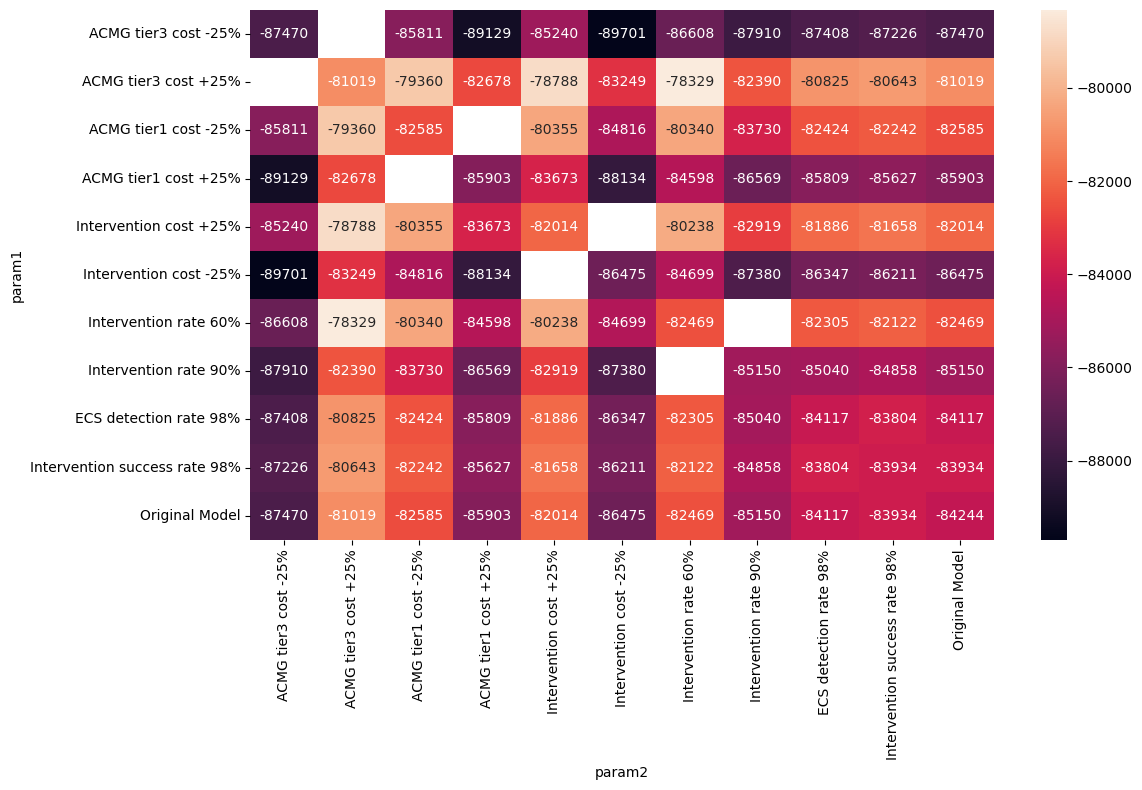

In [22]:
# A vs C


strategy1 = 'Strategy A - ACMG tier 1'
strategy2 = 'Strategy C  - ACMG tier 3'



param_list = [
    ('testing_cost2',0.75*cost_C,'ACMG tier3 cost -25%'),
              ('testing_cost2',1.25*cost_C,'ACMG tier3 cost +25%'),
              ('testing_cost1',0.75*cost_A,'ACMG tier1 cost -25%'),
              ('testing_cost1',1.25*cost_A,'ACMG tier1 cost +25%'),
              ('intervention_cost',1.25*intervention_cost,'Intervention cost +25%'),
              ('intervention_cost',0.75*intervention_cost,'Intervention cost -25%'),
                ('rho_notint',0.4,'Intervention rate 60%'),
              ('rho_notint',0.1,'Intervention rate 90%'),
             ('eps_cs',0.02,'ECS detection rate 98%'),
             ('eps_pgt',0.02,'Intervention success rate 98%'),
    ('original_model_fake_parameter',0,'Original Model')]

df_icer_sensitivity = pd.DataFrame()

for param1 in param_list:
    for param2 in param_list:
        
        if (param1[1]!=param2[1])&(param1[0]==param2[0]):
            pass
        
        else:

            #print(param1,param2)

            icer = Icer(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2],
                     eps_cs=0,eps_pgt=0,intervention_cost=intervention_cost,rho_notint=rho_notint)
            setattr(icer,param1[0],param1[1])
            setattr(icer,param2[0],param2[1])


            icer.compute_icer()
            df_icer_sensitivity = df_icer_sensitivity.append(
            {'param1':param1[2],'param1_value':param1[1],
             'param2':param2[2],'param2_value':param2[1],
               'icer':icer.icer,
               'total cost1':icer.total_cost1,
               'total cost2':icer.total_cost2,
               'life exp1':icer.life_exp1,
               'life exp2':icer.life_exp2,
              'benefit difference (years)':icer.life_exp1-icer.life_exp2,
            'cost difference (Euros)':icer.total_cost1-icer.total_cost2},ignore_index=True)

df_pivot = df_icer_sensitivity.pivot_table(index='param1',columns='param2',values='icer')
params = [x[2] for x in param_list]
df_pivot = df_pivot.loc[params,params]

fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(ax=ax,data = df_pivot, annot=True, fmt=".0f")
plt.tight_layout()
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.eps'))
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.jpeg'))

/tmp/ipykernel_419595/3804463164.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/3804463164.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/3804463164.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/3804463164.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/3804463164.py:41: FutureWarning: The frame.append method is deprecated and wil

/tmp/ipykernel_419595/3804463164.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/3804463164.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/3804463164.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/3804463164.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/3804463164.py:41: FutureWarning: The frame.append method is deprecated and wil

/tmp/ipykernel_419595/3804463164.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/3804463164.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/3804463164.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/3804463164.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/3804463164.py:41: FutureWarning: The frame.append method is deprecated and wil

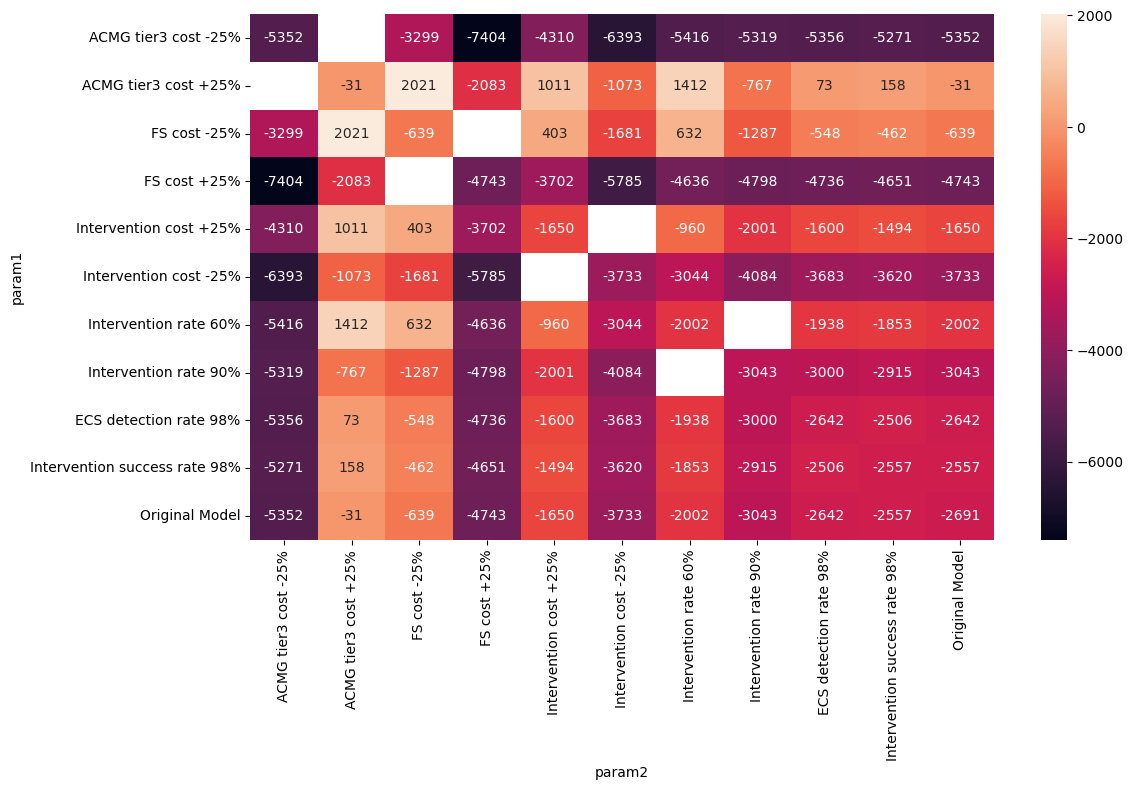

In [23]:
# B vs C


strategy1 = 'Strategy B - Focused Screening'
strategy2 = 'Strategy C  - ACMG tier 3'



param_list = [
    ('testing_cost2',0.75*cost_C,'ACMG tier3 cost -25%'),
              ('testing_cost2',1.25*cost_C,'ACMG tier3 cost +25%'),
              ('testing_cost1',0.75*cost_B,'FS cost -25%'),
              ('testing_cost1',1.25*cost_B,'FS cost +25%'),
              ('intervention_cost',1.25*intervention_cost,'Intervention cost +25%'),
              ('intervention_cost',0.75*intervention_cost,'Intervention cost -25%'),
                ('rho_notint',0.4,'Intervention rate 60%'),
              ('rho_notint',0.1,'Intervention rate 90%'),
             ('eps_cs',0.02,'ECS detection rate 98%'),
             ('eps_pgt',0.02,'Intervention success rate 98%'),
    ('original_model_fake_parameter',0,'Original Model')]

df_icer_sensitivity = pd.DataFrame()

for param1 in param_list:
    for param2 in param_list:
        
        if (param1[1]!=param2[1])&(param1[0]==param2[0]):
            pass
        
        else:

            #print(param1,param2)

            icer = Icer(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2],
                     eps_cs=0,eps_pgt=0,intervention_cost=intervention_cost,rho_notint=rho_notint)
            setattr(icer,param1[0],param1[1])
            setattr(icer,param2[0],param2[1])


            icer.compute_icer()
            df_icer_sensitivity = df_icer_sensitivity.append(
            {'param1':param1[2],'param1_value':param1[1],
             'param2':param2[2],'param2_value':param2[1],
               'icer':icer.icer,
               'total cost1':icer.total_cost1,
               'total cost2':icer.total_cost2,
               'life exp1':icer.life_exp1,
               'life exp2':icer.life_exp2,
              'benefit difference (years)':icer.life_exp1-icer.life_exp2,
            'cost difference (Euros)':icer.total_cost1-icer.total_cost2},ignore_index=True)

df_pivot = df_icer_sensitivity.pivot_table(index='param1',columns='param2',values='icer')
params = [x[2] for x in param_list]
df_pivot = df_pivot.loc[params,params]

fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(ax=ax,data = df_pivot, annot=True, fmt=".0f")
plt.tight_layout()
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.eps'))
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.jpeg'))

/tmp/ipykernel_419595/1389881901.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/1389881901.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/1389881901.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/1389881901.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/1389881901.py:44: FutureWarning: The frame.append method is deprecated and wil

/tmp/ipykernel_419595/1389881901.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/1389881901.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/1389881901.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/1389881901.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/1389881901.py:44: FutureWarning: The frame.append method is deprecated and wil

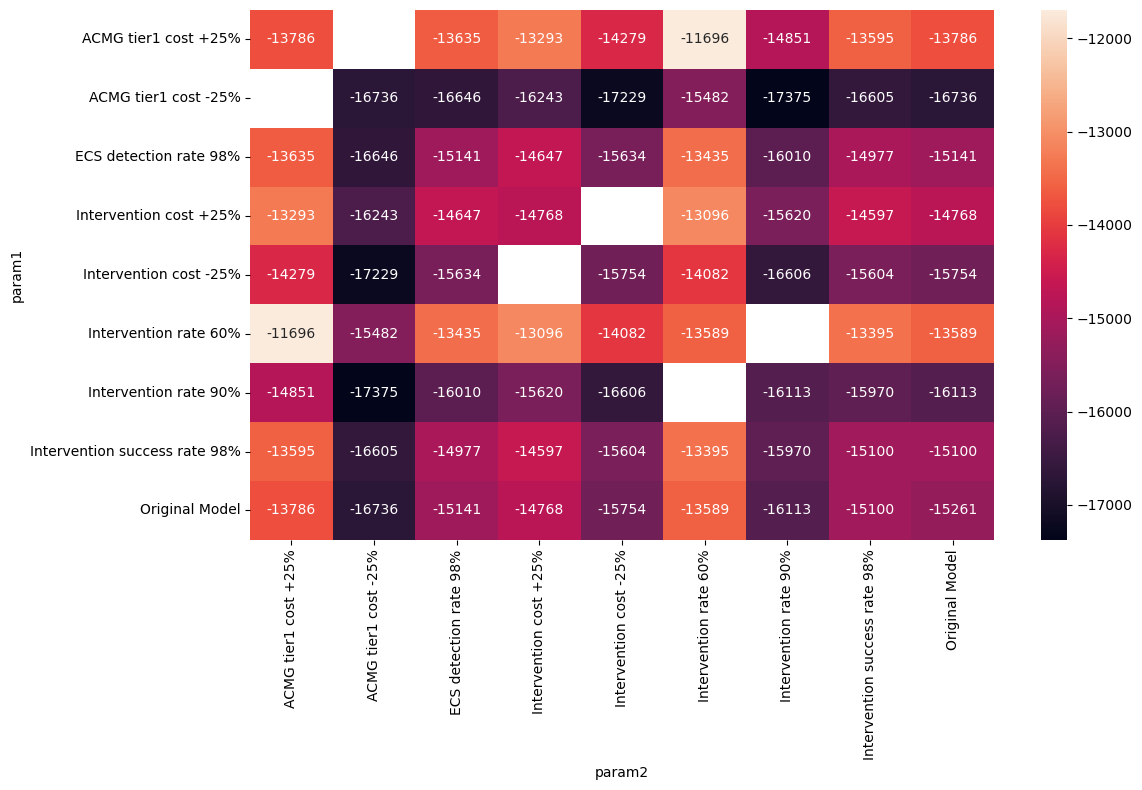

In [24]:
# A vs no testing


strategy1 = 'Strategy A - ACMG tier 1'
strategy2 = 'No testing'



param_list = [
    ('testing_cost1',0.75*cost_A,'ACMG tier1 cost -25%'),
              ('testing_cost1',1.25*cost_A,'ACMG tier1 cost +25%'),
              ('intervention_cost',1.25*intervention_cost,'Intervention cost +25%'),
              ('intervention_cost',0.75*intervention_cost,'Intervention cost -25%'),
                ('rho_notint',0.4,'Intervention rate 60%'),
              ('rho_notint',0.1,'Intervention rate 90%'),
             ('eps_cs',0.02,'ECS detection rate 98%'),
             ('eps_pgt',0.02,'Intervention success rate 98%'),
    ('original_model_fake_parameter',0,'Original Model')]


df_icer_sensitivity = pd.DataFrame()

for idx1 in range(len(param_list)):
    for idx2 in range(len(param_list)):
        
        param1 = param_list[idx1]
        param2 = param_list[idx2]
        #print(param1,param2)

        
        if (param1[1]!=param2[1])&(param1[0]==param2[0]):
            pass
        
        else:
        
        
            icer = Icer(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2],
                     eps_cs=0,eps_pgt=0,intervention_cost=intervention_cost,rho_notint=rho_notint)
            setattr(icer,param1[0],param1[1])
            setattr(icer,param2[0],param2[1])


            icer.compute_icer()
            df_icer_sensitivity = df_icer_sensitivity.append(
            {'param1':param1[2],'param1_value':param1[1],
             'param2':param2[2],'param2_value':param2[1],
               'icer':icer.icer,
               'total cost1':icer.total_cost1,
               'total cost2':icer.total_cost2,
               'life exp1':icer.life_exp1,
               'life exp2':icer.life_exp2,
              'benefit difference (years)':icer.life_exp1-icer.life_exp2,
            'cost difference (Euros)':icer.total_cost1-icer.total_cost2},ignore_index=True)

df_pivot = df_icer_sensitivity.pivot_table(index='param1',columns='param2',values='icer')
params = [x[2] for x in param_list]
#df_pivot = df_pivot.loc[params,params]

fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(ax=ax,data = df_pivot, annot=True, fmt=".0f")
plt.tight_layout()
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.eps'))
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.jpeg'))

/tmp/ipykernel_419595/1520417552.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/1520417552.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/1520417552.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/1520417552.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/1520417552.py:42: FutureWarning: The frame.append method is deprecated and wil

/tmp/ipykernel_419595/1520417552.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/1520417552.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/1520417552.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/1520417552.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/1520417552.py:42: FutureWarning: The frame.append method is deprecated and wil

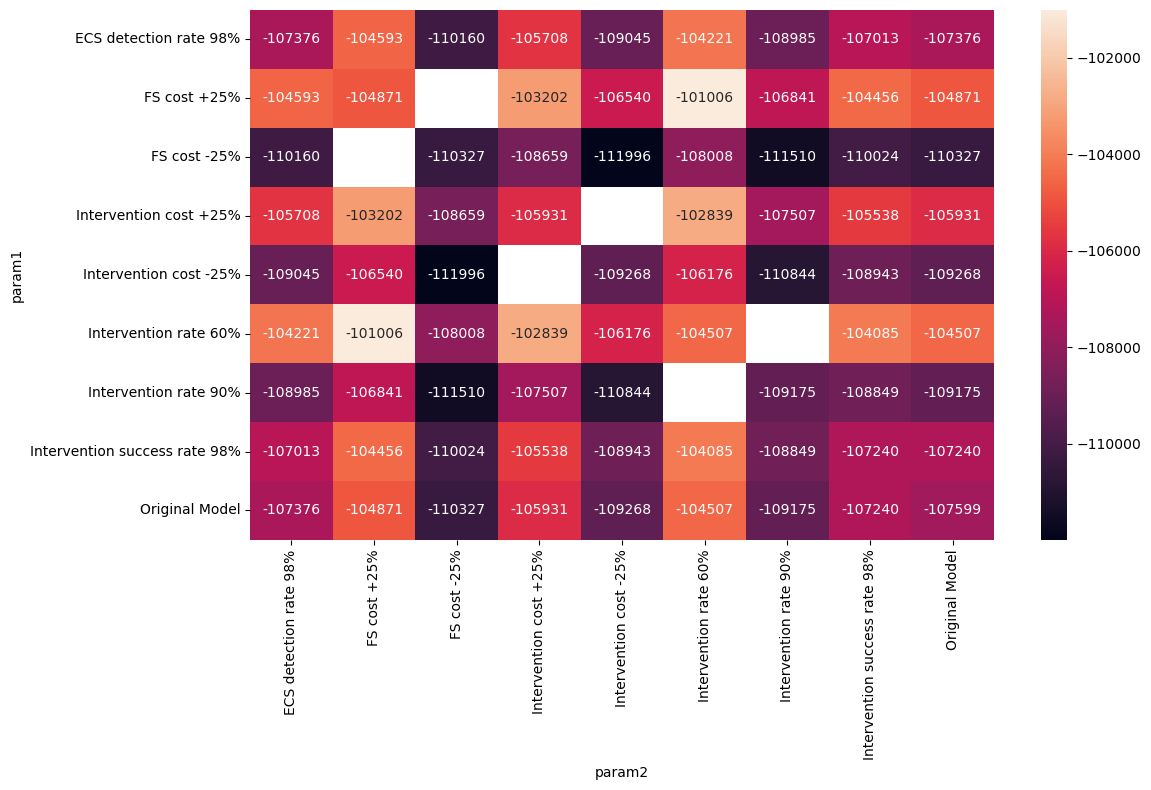

In [25]:
# B vs no testing


strategy1 = 'Strategy B - Focused Screening'
strategy2 = 'No testing'

param_list = [
    ('testing_cost1',0.75*cost_B,'FS cost -25%'),
              ('testing_cost1',1.25*cost_B,'FS cost +25%'),
              ('intervention_cost',1.25*intervention_cost,'Intervention cost +25%'),
              ('intervention_cost',0.75*intervention_cost,'Intervention cost -25%'),
                ('rho_notint',0.4,'Intervention rate 60%'),
              ('rho_notint',0.1,'Intervention rate 90%'),
             ('eps_cs',0.02,'ECS detection rate 98%'),
             ('eps_pgt',0.02,'Intervention success rate 98%'),
    ('original_model_fake_parameter',0,'Original Model')]


df_icer_sensitivity = pd.DataFrame()

for idx1 in range(len(param_list)):
    for idx2 in range(len(param_list)):
        
        param1 = param_list[idx1]
        param2 = param_list[idx2]
        #print(param1,param2)

        
        if (param1[1]!=param2[1])&(param1[0]==param2[0]):
            pass
        
        else:
        
        
            icer = Icer(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2],
                     eps_cs=0,eps_pgt=0,intervention_cost=intervention_cost,rho_notint=rho_notint)
            setattr(icer,param1[0],param1[1])
            setattr(icer,param2[0],param2[1])


            icer.compute_icer()
            df_icer_sensitivity = df_icer_sensitivity.append(
            {'param1':param1[2],'param1_value':param1[1],
             'param2':param2[2],'param2_value':param2[1],
               'icer':icer.icer,
               'total cost1':icer.total_cost1,
               'total cost2':icer.total_cost2,
               'life exp1':icer.life_exp1,
               'life exp2':icer.life_exp2,
              'benefit difference (years)':icer.life_exp1-icer.life_exp2,
            'cost difference (Euros)':icer.total_cost1-icer.total_cost2},ignore_index=True)

df_pivot = df_icer_sensitivity.pivot_table(index='param1',columns='param2',values='icer')
params = [x[2] for x in param_list]
#df_pivot = df_pivot.loc[params,params]

fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(ax=ax,data = df_pivot, annot=True, fmt=".0f")
plt.tight_layout()
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.eps'))
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.jpeg'))

/tmp/ipykernel_419595/2961297374.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/2961297374.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/2961297374.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/2961297374.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/2961297374.py:42: FutureWarning: The frame.append method is deprecated and wil

/tmp/ipykernel_419595/2961297374.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/2961297374.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/2961297374.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/2961297374.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_icer_sensitivity = df_icer_sensitivity.append(
/tmp/ipykernel_419595/2961297374.py:42: FutureWarning: The frame.append method is deprecated and wil

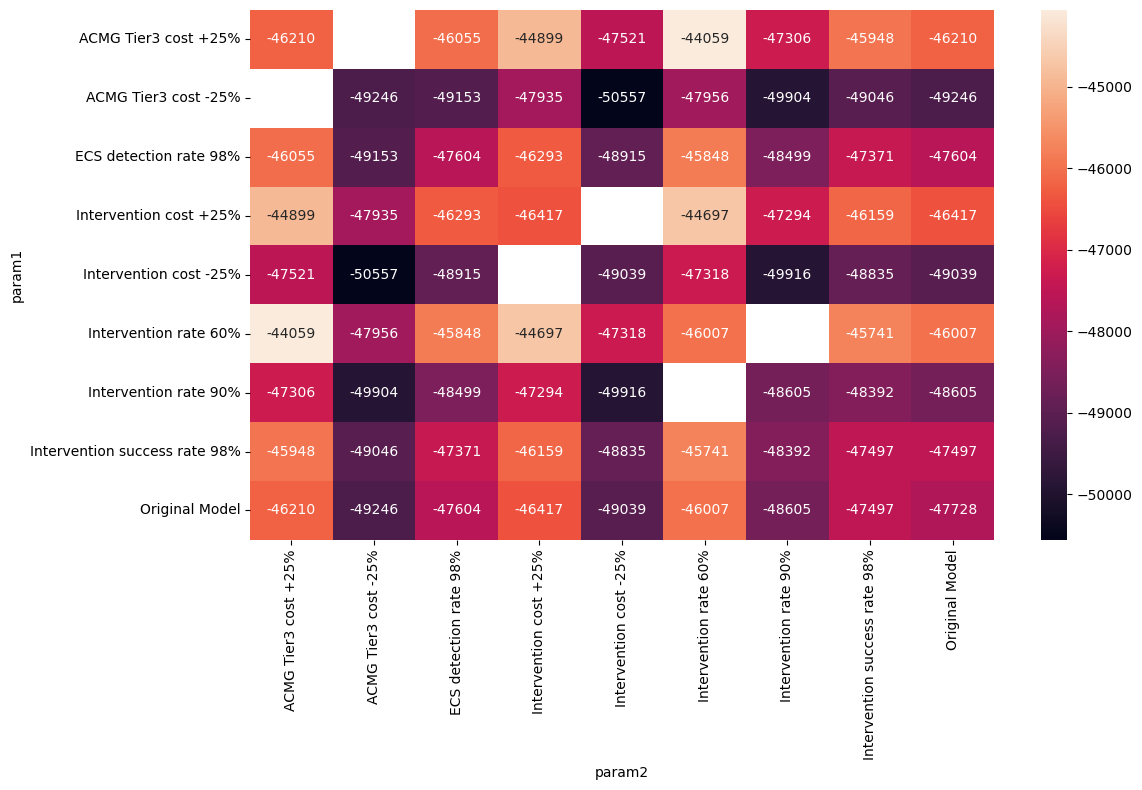

In [26]:
# C vs no testing


strategy1 = 'Strategy C  - ACMG tier 3'
strategy2 = 'No testing'

param_list = [
    ('testing_cost1',0.75*cost_C,'ACMG Tier3 cost -25%'),
              ('testing_cost1',1.25*cost_C,'ACMG Tier3 cost +25%'),
              ('intervention_cost',1.25*intervention_cost,'Intervention cost +25%'),
              ('intervention_cost',0.75*intervention_cost,'Intervention cost -25%'),
                ('rho_notint',0.4,'Intervention rate 60%'),
              ('rho_notint',0.1,'Intervention rate 90%'),
             ('eps_cs',0.02,'ECS detection rate 98%'),
             ('eps_pgt',0.02,'Intervention success rate 98%'),
    ('original_model_fake_parameter',0,'Original Model')]


df_icer_sensitivity = pd.DataFrame()

for idx1 in range(len(param_list)):
    for idx2 in range(len(param_list)):
        
        param1 = param_list[idx1]
        param2 = param_list[idx2]
        #print(param1,param2)

        
        if (param1[1]!=param2[1])&(param1[0]==param2[0]):
            pass
        
        else:
        
        
            icer = Icer(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2],
                     eps_cs=0,eps_pgt=0,intervention_cost=intervention_cost,rho_notint=rho_notint)
            setattr(icer,param1[0],param1[1])
            setattr(icer,param2[0],param2[1])


            icer.compute_icer()
            df_icer_sensitivity = df_icer_sensitivity.append(
            {'param1':param1[2],'param1_value':param1[1],
             'param2':param2[2],'param2_value':param2[1],
               'icer':icer.icer,
               'total cost1':icer.total_cost1,
               'total cost2':icer.total_cost2,
               'life exp1':icer.life_exp1,
               'life exp2':icer.life_exp2,
              'benefit difference (years)':icer.life_exp1-icer.life_exp2,
            'cost difference (Euros)':icer.total_cost1-icer.total_cost2},ignore_index=True)

df_pivot = df_icer_sensitivity.pivot_table(index='param1',columns='param2',values='icer')
params = [x[2] for x in param_list]
#df_pivot = df_pivot.loc[params,params]

fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(ax=ax,data = df_pivot, annot=True, fmt=".0f")
plt.tight_layout()
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.eps'))
plt.savefig(os.path.join(out_folder,'bivariate_'+strategy1+'vs'+strategy2+'.jpeg'))

# Probabilistic analysis

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


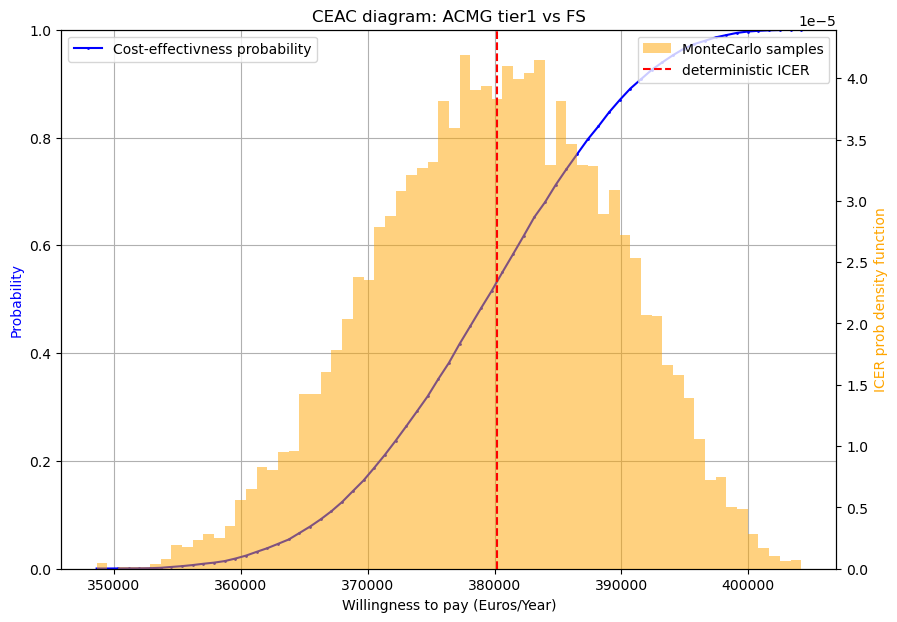

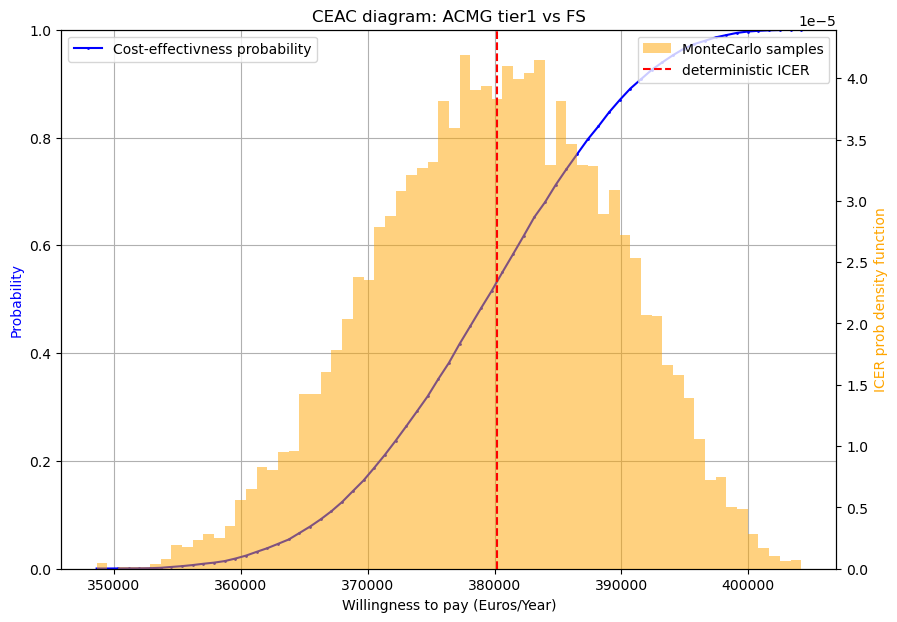

In [27]:

strategy1 = 'Strategy A - ACMG tier 1'
strategy2 = 'Strategy B - Focused Screening'

psa = Psa(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2])
psa.run_mc(
    intervention_cost_lb=intervention_cost*0.75, intervention_cost_ub=intervention_cost*1.25,
       testing_cost1_lb=0.75*cost_A, testing_cost1_ub=1.25*cost_A,
        testing_cost2_lb=0.75*cost_B, testing_cost2_ub=1.25*cost_B,
        eps_cs_lb=0,eps_cs_ub=0.02,
        eps_pgt_lb=0,eps_pgt_ub=0.02,
        rho_notint_lb=0.1,rho_notint_ub=0.4,nsim=10000)



outfile = os.path.join(out_folder,'psa_'+strategy1+'vs'+strategy2+'.jpeg')
psa.plot_ceac_hist(outfile=outfile,title='CEAC diagram: ACMG tier1 vs FS')

outfile = os.path.join(out_folder,'psa_'+strategy1+'vs'+strategy2+'.eps')
psa.plot_ceac_hist(outfile=outfile,title='CEAC diagram: ACMG tier1 vs FS')

In [22]:
import numpy as np
print(np.mean(psa.icer_mc_samples))
print(np.std(psa.icer_mc_samples))
print(np.std(psa.icer_mc_samples)/np.mean(psa.icer_mc_samples))

379940.5223799691
9270.350572040528
0.024399478407753205


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


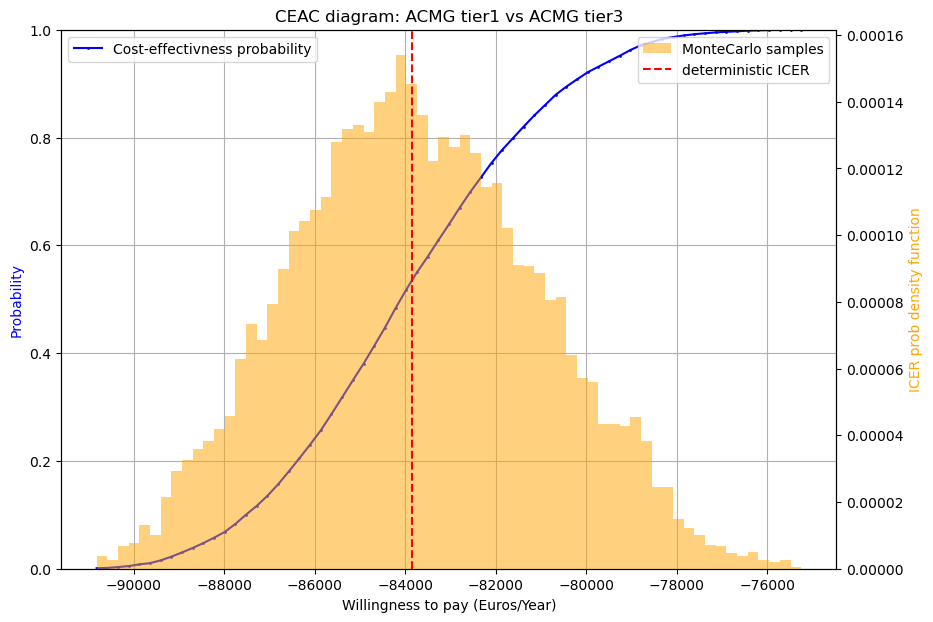

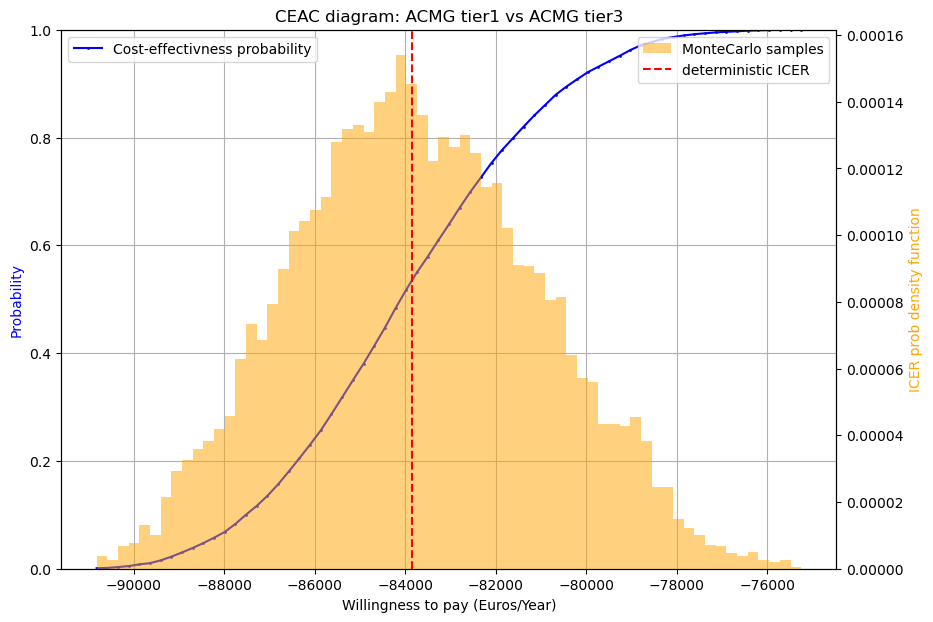

In [28]:

strategy1 = 'Strategy A - ACMG tier 1'
strategy2 = 'Strategy C  - ACMG tier 3'

psa = Psa(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2])
psa.run_mc(
    intervention_cost_lb=intervention_cost*0.75, intervention_cost_ub=intervention_cost*1.25,
       testing_cost1_lb=0.75*cost_A, testing_cost1_ub=1.25*cost_A,
        testing_cost2_lb=0.75*cost_C, testing_cost2_ub=1.25*cost_C,
        eps_cs_lb=0,eps_cs_ub=0.02,
        eps_pgt_lb=0,eps_pgt_ub=0.02,
        rho_notint_lb=0.1,rho_notint_ub=0.4,nsim=10000)



outfile = os.path.join(out_folder,'psa_'+strategy1+'vs'+strategy2+'.jpeg')
psa.plot_ceac_hist(outfile=outfile,title='CEAC diagram: ACMG tier1 vs ACMG tier3')

outfile = os.path.join(out_folder,'psa_'+strategy1+'vs'+strategy2+'.eps')
psa.plot_ceac_hist(outfile=outfile,title='CEAC diagram: ACMG tier1 vs ACMG tier3')

In [24]:
print(np.mean(psa.icer_mc_samples))
print(np.std(psa.icer_mc_samples))
print(np.std(psa.icer_mc_samples)/np.mean(psa.icer_mc_samples))

-83768.05802411417
2721.886529487787
-0.03249313155504025


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


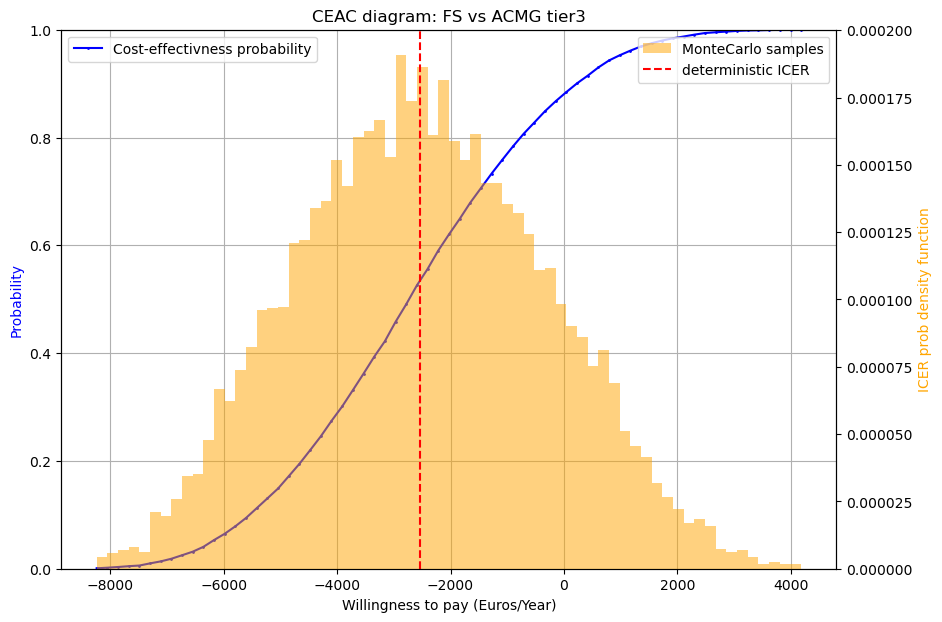

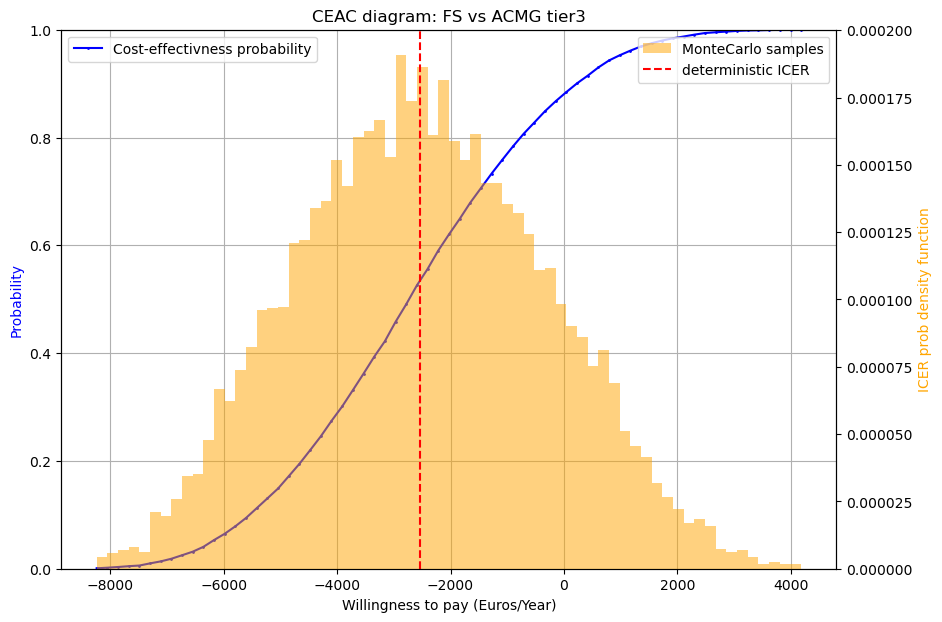

In [29]:

strategy1 = 'Strategy B - Focused Screening'
strategy2 = 'Strategy C  - ACMG tier 3'

psa = Psa(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2])
psa.run_mc(
    intervention_cost_lb=intervention_cost*0.75, intervention_cost_ub=intervention_cost*1.25,
       testing_cost1_lb=0.75*cost_B, testing_cost1_ub=1.25*cost_B,
        testing_cost2_lb=0.75*cost_C, testing_cost2_ub=1.25*cost_C,
        eps_cs_lb=0,eps_cs_ub=0.02,
        eps_pgt_lb=0,eps_pgt_ub=0.02,
        rho_notint_lb=0.1,rho_notint_ub=0.4,nsim=10000)



outfile = os.path.join(out_folder,'psa_'+strategy1+'vs'+strategy2+'.jpeg')
psa.plot_ceac_hist(outfile=outfile,title='CEAC diagram: FS vs ACMG tier3')

outfile = os.path.join(out_folder,'psa_'+strategy1+'vs'+strategy2+'.eps')
psa.plot_ceac_hist(outfile=outfile,title='CEAC diagram: FS vs ACMG tier3')

In [26]:
print(np.mean(psa.icer_mc_samples))
print(np.std(psa.icer_mc_samples))
print(np.std(psa.icer_mc_samples)/np.mean(psa.icer_mc_samples))

-2487.03262249654
2183.0182095782598
-0.877760182890925


In [27]:
psa.icer_mc_samples

[-4346.47934951645,
 -2230.5104701328833,
 -693.3457031445442,
 3753.698276887812,
 -5083.021193323066,
 -4525.762333195697,
 -6705.81262987938,
 -4005.3745480029725,
 -1310.499325340744,
 -3528.11609960115,
 -3368.5354048360896,
 -2043.9914420367927,
 707.0819308505506,
 -596.5420319694105,
 -279.8120612373816,
 -2402.0913747490213,
 -643.9925155036169,
 -1822.2030468962025,
 -3297.5633707335546,
 -2103.451131989061,
 -1930.367951712827,
 -281.5730491992902,
 264.36061984120187,
 -6197.965743515429,
 -6942.73798144186,
 -3202.4652402726606,
 -4558.182144522592,
 -2998.166213060467,
 -1314.3070853866534,
 24.975131757369287,
 -1330.261563410363,
 -3720.212791505566,
 -1589.2613691369015,
 -2402.2314911109397,
 -1626.2780574734609,
 -1342.0194806651468,
 -6815.468398034388,
 -4246.888259236387,
 -6020.810370053445,
 -2464.784973365317,
 -2072.2760379496835,
 -906.4143637918544,
 -1567.9131221578516,
 -1336.6972920682776,
 -1513.6504295650618,
 -4385.309435818446,
 -4011.499122623482,
 -

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


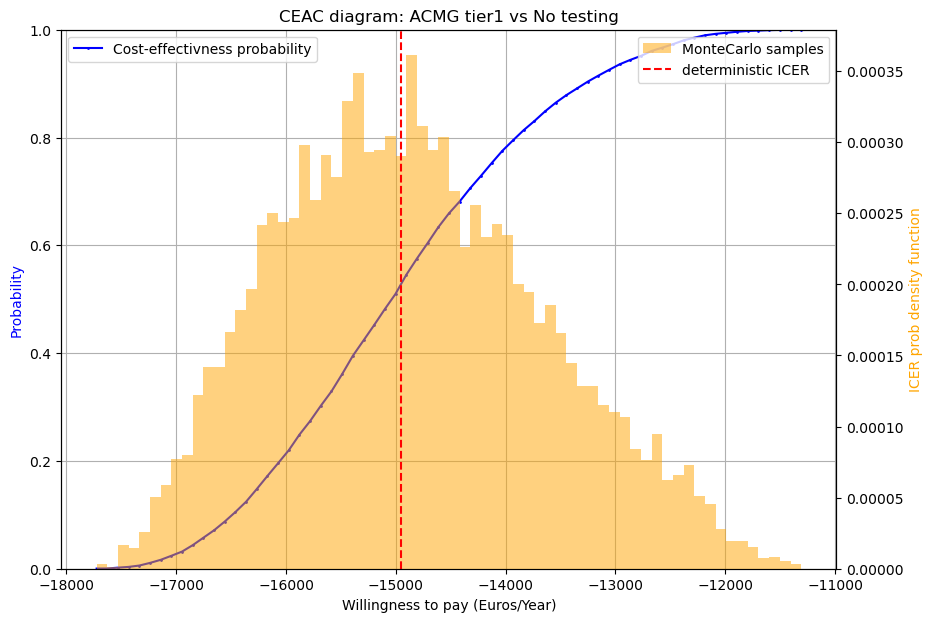

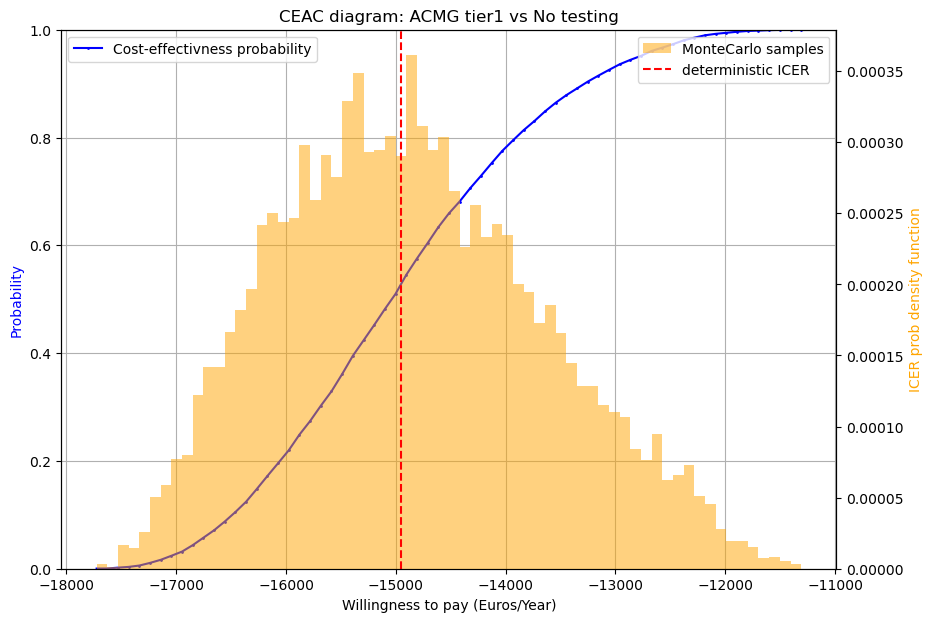

In [30]:

strategy1 = 'Strategy A - ACMG tier 1'
strategy2 = 'No testing'

psa = Psa(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2])
psa.run_mc(
    intervention_cost_lb=intervention_cost*0.75, intervention_cost_ub=intervention_cost*1.25,
       testing_cost1_lb=0.75*cost_A, testing_cost1_ub=1.25*cost_A,
        testing_cost2_lb=0, testing_cost2_ub=0,
        eps_cs_lb=0,eps_cs_ub=0.02,
        eps_pgt_lb=0,eps_pgt_ub=0.02,
        rho_notint_lb=0.1,rho_notint_ub=0.4,nsim=10000)


outfile = os.path.join(out_folder,'psa_'+strategy1+'vs'+strategy2+'.eps')
psa.plot_ceac_hist(outfile=outfile,title='CEAC diagram: ACMG tier1 vs No testing')

outfile = os.path.join(out_folder,'psa_'+strategy1+'vs'+strategy2+'.jpeg')
psa.plot_ceac_hist(outfile=outfile,title='CEAC diagram: ACMG tier1 vs No testing')

In [29]:
print(np.mean(psa.icer_mc_samples))
print(np.std(psa.icer_mc_samples))
print(np.std(psa.icer_mc_samples)/np.mean(psa.icer_mc_samples))

-14875.174081057436
1206.1664698708253
-0.0810858725617739


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


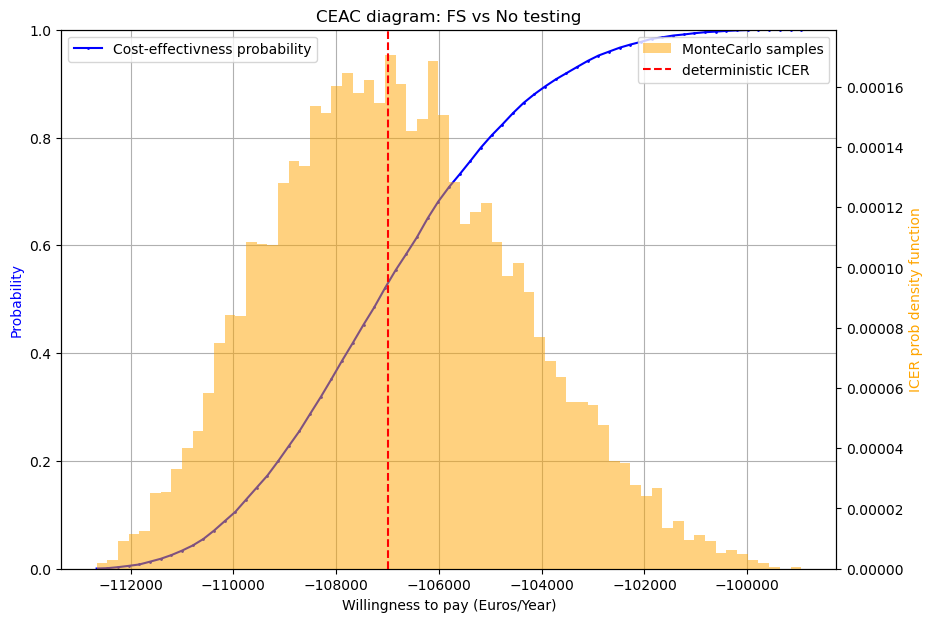

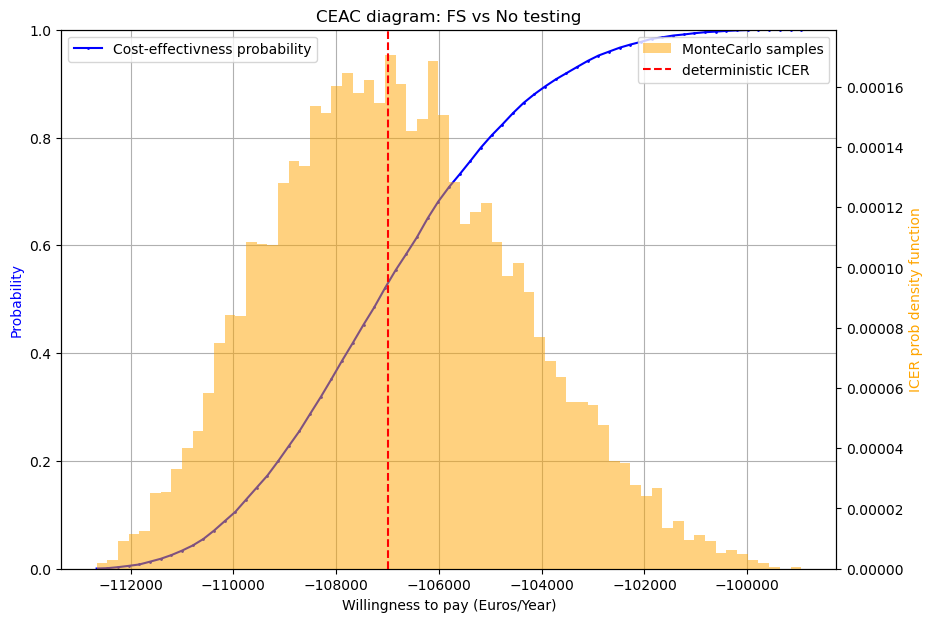

In [31]:

strategy1 = 'Strategy B - Focused Screening'
strategy2 = 'No testing'

psa = Psa(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2])
psa.run_mc(
    intervention_cost_lb=intervention_cost*0.75, intervention_cost_ub=intervention_cost*1.25,
       testing_cost1_lb=0.75*cost_B, testing_cost1_ub=1.25*cost_B,
        testing_cost2_lb=0, testing_cost2_ub=0,
        eps_cs_lb=0,eps_cs_ub=0.02,
        eps_pgt_lb=0,eps_pgt_ub=0.02,
        rho_notint_lb=0.1,rho_notint_ub=0.4,nsim=10000)


outfile = os.path.join(out_folder,'psa_'+strategy1+'vs'+strategy2+'.eps')
psa.plot_ceac_hist(outfile=outfile,title='CEAC diagram: FS vs No testing')

outfile = os.path.join(out_folder,'psa_'+strategy1+'vs'+strategy2+'.jpeg')
psa.plot_ceac_hist(outfile=outfile,title='CEAC diagram: FS vs No testing')

In [31]:
print(np.mean(psa.icer_mc_samples))
print(np.std(psa.icer_mc_samples))
print(np.std(psa.icer_mc_samples)/np.mean(psa.icer_mc_samples))

-106825.13587423801
2369.697961437517
-0.022182962296694763


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


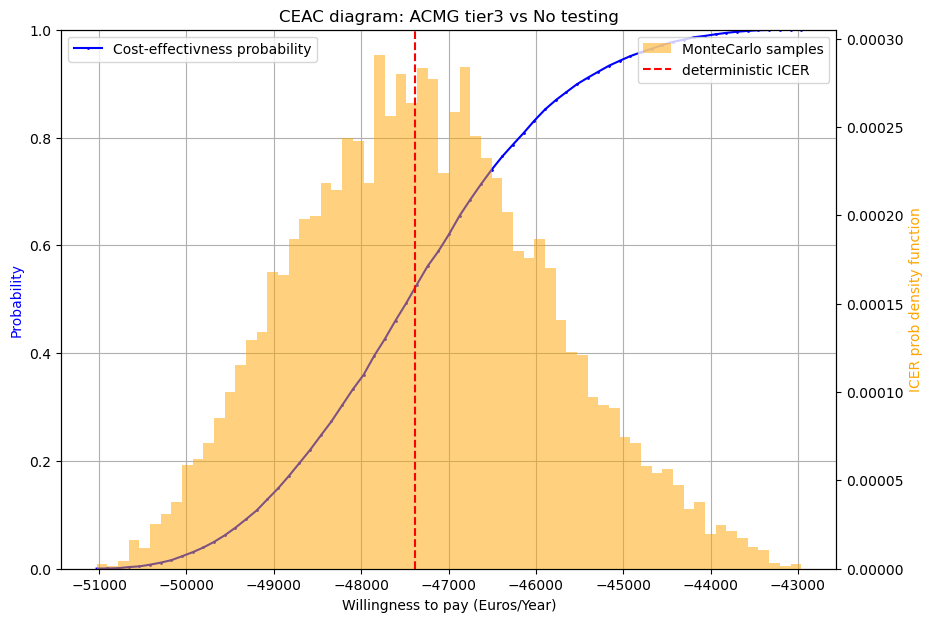

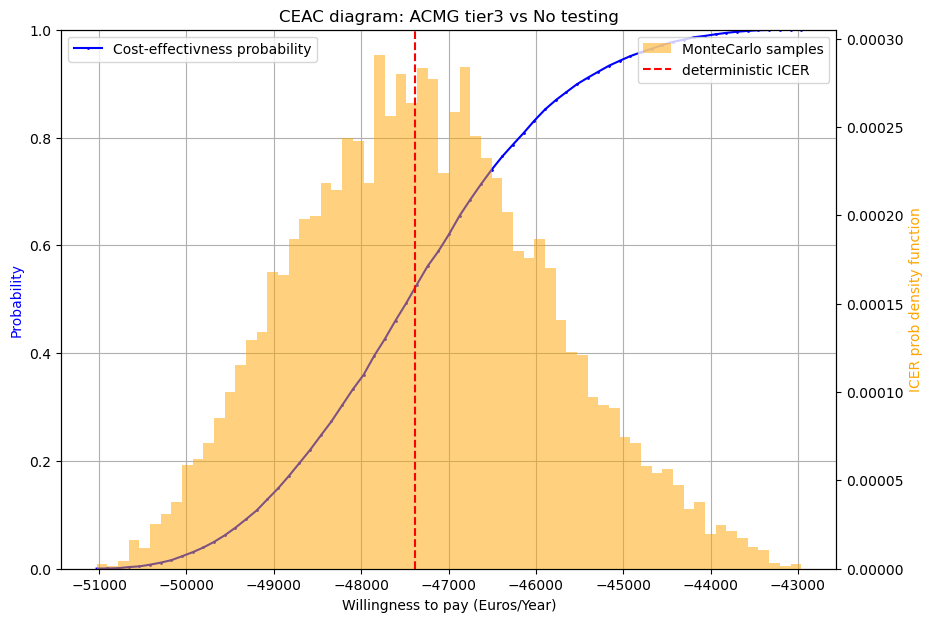

In [32]:

strategy1 = 'Strategy C  - ACMG tier 3'
strategy2 = 'No testing'

psa = Psa(dl.strategy_dict[strategy1],dl.strategy_dict[strategy2])
psa.run_mc(
    intervention_cost_lb=intervention_cost*0.75, intervention_cost_ub=intervention_cost*1.25,
       testing_cost1_lb=0.75*cost_C, testing_cost1_ub=1.25*cost_C,
        testing_cost2_lb=0, testing_cost2_ub=0,
        eps_cs_lb=0,eps_cs_ub=0.02,
        eps_pgt_lb=0,eps_pgt_ub=0.02,
        rho_notint_lb=0.1,rho_notint_ub=0.4,nsim=10000)


outfile = os.path.join(out_folder,'psa_'+strategy1+'vs'+strategy2+'.eps')
psa.plot_ceac_hist(outfile=outfile,title='CEAC diagram: ACMG tier3 vs No testing')

outfile = os.path.join(out_folder,'psa_'+strategy1+'vs'+strategy2+'.jpeg')
psa.plot_ceac_hist(outfile=outfile,title='CEAC diagram: ACMG tier3 vs No testing')

In [33]:
print(np.mean(psa.icer_mc_samples))
print(np.std(psa.icer_mc_samples))
print(np.std(psa.icer_mc_samples)/np.mean(psa.icer_mc_samples))

-47296.150244464996
1434.0247003104757
-0.030320114700631427


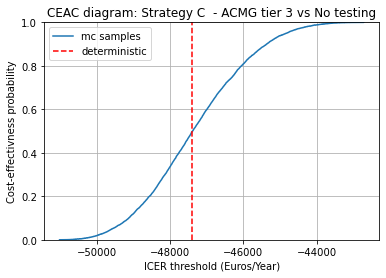

In [31]:
psa.plot_ceac()